In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data() #_: Placeholder for training labels (which we're ignoring)

# Normalize pixel values between [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape and add channel dimension (for grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [4]:
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0., 1.)

def add_salt_pepper_noise(images, salt_prob=0.01, pepper_prob=0.01):
    noisy_images = np.copy(images)
    total_pixels = images.size
    
    # Add salt noise
    salt_mask = np.random.rand(*images.shape) < salt_prob
    noisy_images[salt_mask] = 1
    
    # Add pepper noise
    pepper_mask = np.random.rand(*images.shape) < pepper_prob
    noisy_images[pepper_mask] = 0
    
    return noisy_images

def add_blur(images, kernel_size=(3,3)):
    # Simple averaging blur
    blurred_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        blurred_images[i] = cv2.blur(images[i], kernel_size)
    return blurred_images

# Create degraded versions
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

# Alternatively, you can combine different degradations
# x_train_noisy = add_salt_pepper_noise(add_blur(x_train))

In [5]:
def add_gausian(images, mean=0, std=0.1):
    nosie=np.random.normal(mean, std, size=images.shape)
    noisy_image=images+noise
    return np.clip(noisy_images, 0.,1,) #-so that pixel val stays in 0,1

def add_salt_and_pepper(images, salt_prob=0.01, pepper_prob=0.01):
    noisy_images = np.copy(images)
    salt_mask = np.random.rand(*images.shape)<salt_prob #-rana arr of same shape as images booleasn
    noisy_images[salt_mask]=1 #selected pixels to 1 Only pixels where salt_mask == True are set to 1 (maximum brightness).
    pepper_mask=np.random.rand(*images.shape)<pepper_prob
    noisy_images[pepper_mask]=0 
    return noisy_images

def add_blur(images, kernel_size=(3,3)):
    blurred_images= np.zeros_like(images)
    for i in range(images.shapes[0]):
        blurred_images[i]=cv2.blur(images[i], kernel_size)
    return blurred_images    

In [6]:

x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)



In [7]:
def build_autoencoder(input_shape=(28, 28, 1)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1191 - val_loss: 0.1140
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1124 - val_loss: 0.1140
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

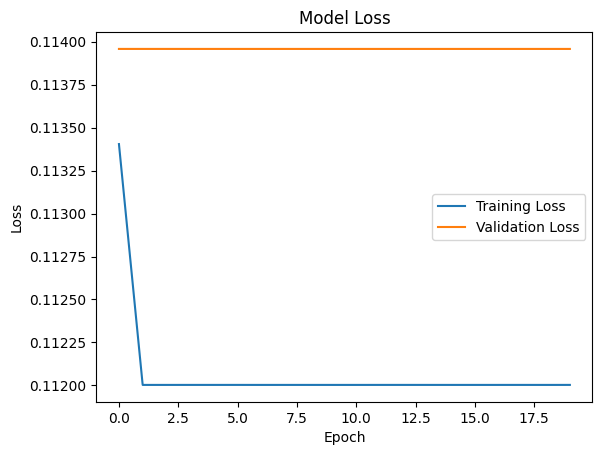

In [8]:
# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Predict restored images
restored_images = autoencoder.predict(x_test_noisy)

# Calculate PSNR for test set
psnr_values = []
for i in range(len(x_test)):
    psnr = calculate_psnr(x_test[i], restored_images[i])
    psnr_values.append(psnr)

print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Average PSNR: 9.73 dB


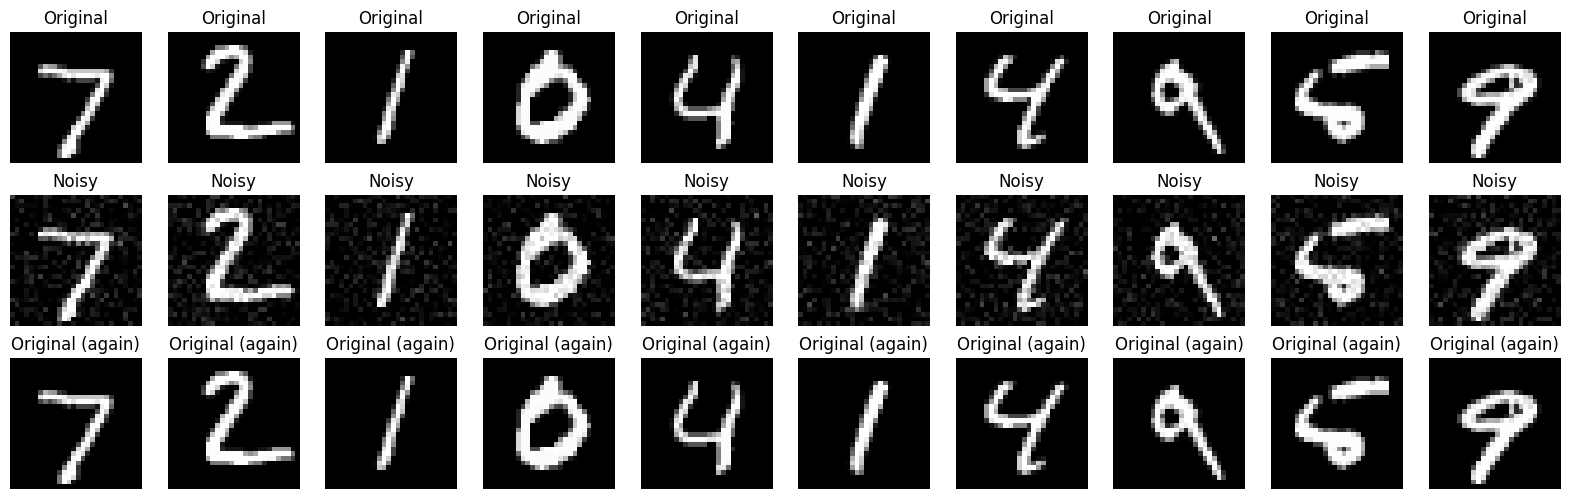

In [11]:


n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Original image again (instead of reconstructed)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original (again)")
    plt.axis("off")
plt.show()


In [15]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [20]:
 def build_alexnet(input_shape=(32, 32, 3), num_classes=100):
    inputs = Input(shape=input_shape)
    
    # Block 1 - Adjusted for 32x32 input
    x = Conv2D(96, (3, 3), strides=1, activation='relu', padding='same')(inputs)  # Changed from (11,11) stride 4
    x = MaxPooling2D((2, 2), strides=2)(x)  # Changed from (3,3) stride 2
    x = BatchNormalization()(x)
    
    # Block 2
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Changed from (5,5)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Changed from (3,3) stride 2
    x = BatchNormalization()(x)
    
    # Block 3
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Changed from (3,3) stride 2
    
    # Classifier
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)  # Reduced from 4096
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)  # Reduced from 4096
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

Training AlexNet...
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.0420 - loss: 4.4115 - val_accuracy: 0.0451 - val_loss: 4.3575
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.1375 - loss: 3.6766 - val_accuracy: 0.2376 - val_loss: 3.1827
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2086 - loss: 3.2650 - val_accuracy: 0.3015 - val_loss: 2.8275
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2759 - loss: 2.9113 - val_accuracy: 0.3578 - val_loss: 2.5578
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.3289 - loss: 2.6179 - val_accuracy: 0.3881 - val_loss: 2.3957
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.3782 - loss: 2.3930 - val_accuracy: 0.4172 - val_loss: 2.2582
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4182 - loss: 2.1893 - val_accuracy: 0.4375 - val_loss: 2.1601
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.46

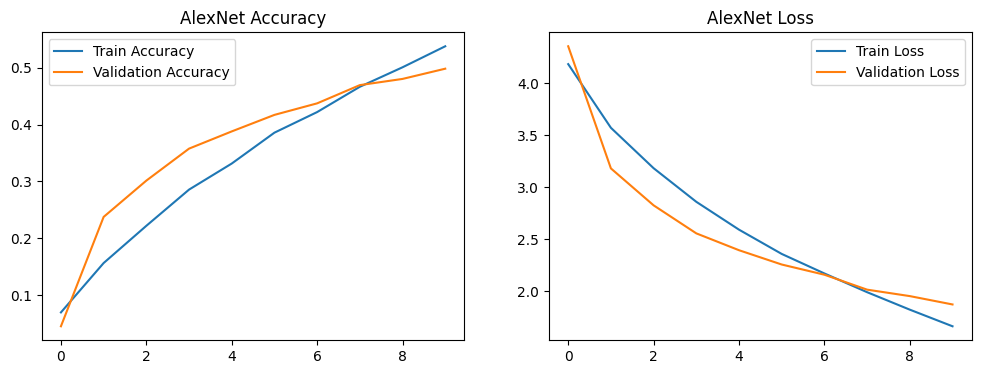

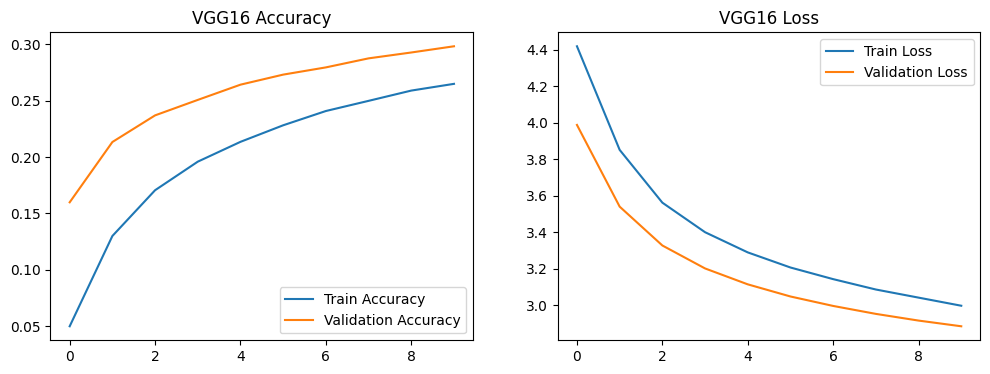

     Model  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0  AlexNet         0.53796        0.4985    1.664104  1.874003
1    VGG16         0.26482        0.2981    2.997921  2.885344


In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def build_alexnet(input_shape=(32, 32, 3), num_classes=100):
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(96, (3, 3), strides=1, activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = BatchNormalization()(x)
    
    # Block 2
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = BatchNormalization()(x)
    
    # Block 3
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=2)(x)
    
    # Classifier
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

def build_vgg16(input_shape=(32, 32, 3), num_classes=100):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Build models
alexnet = build_alexnet()
vgg16 = build_vgg16()

# Compile models
alexnet.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

vgg16.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train models
batch_size = 128
epochs = 10

print("Training AlexNet...")
alexnet_history = alexnet.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)

print("\nTraining VGG16...")
vgg16_history = vgg16.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(x_test, y_test),
                         verbose=1)

# Plot results
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

plot_history(alexnet_history, 'AlexNet')
plot_history(vgg16_history, 'VGG16')

# Compare results
results = pd.DataFrame({
    'Model': ['AlexNet', 'VGG16'],
    'Train Accuracy': [alexnet_history.history['accuracy'][-1], vgg16_history.history['accuracy'][-1]],
    'Val Accuracy': [alexnet_history.history['val_accuracy'][-1], vgg16_history.history['val_accuracy'][-1]],
    'Train Loss': [alexnet_history.history['loss'][-1], vgg16_history.history['loss'][-1]],
    'Val Loss': [alexnet_history.history['val_loss'][-1], vgg16_history.history['val_loss'][-1]]
})

print(results)